# Taller # 3

In [8]:
# Librerías estándar
import os
import glob
import pandas as pd
# Procesamiento de imágenes
import cv2
import numpy as np
import sounddevice as sd
# Visualización
import matplotlib.pyplot as plt

# Scikit-learn: modelos y métricas
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix as cm, ConfusionMatrixDisplay as CMD

# TensorFlow / Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical


<Axes: >

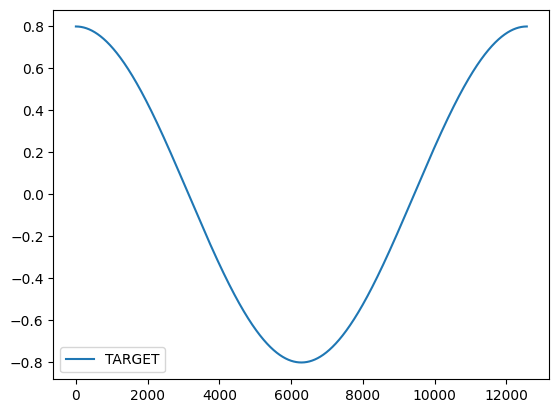

In [4]:
train = pd.read_csv('Insumos/train.csv')
test = pd.read_csv('Insumos/test.csv')

train.plot(y='TARGET')

In [13]:
import numpy as np

def cosine_model(params, x_val):
    amp, freq, phase, offset = params
    return amp * np.cos(freq * x_val + phase) + offset

def compute_gradients(params, x_sample, y_sample):
    amp, freq, phase, offset = params
    pred_val = cosine_model(params, x_sample)
    diff = y_sample - pred_val
    grad_amp = -2 * np.mean(diff * np.cos(freq * x_sample + phase))
    grad_freq = 2 * np.mean(diff * amp * x_sample * np.sin(freq * x_sample + phase))
    grad_phase = 2 * np.mean(diff * amp * np.sin(freq * x_sample + phase))
    grad_offset = -2 * np.mean(diff)
    return np.array([grad_amp, grad_freq, grad_phase, grad_offset])

def fit_cosine(x_data, y_data, learning_rate=0.05, mini_batch=100, n_iter=3000, random_state=42):
    rng = np.random.default_rng(random_state)
    parameters = rng.standard_normal(4)
    history = []

    for step in range(n_iter):
        grad_sum = np.zeros(4)
        batch_loss = 0.0

        for _ in range(mini_batch):
            idx = rng.integers(0, len(x_data))
            xi, yi = x_data[idx], y_data[idx]
            pred_i = cosine_model(parameters, xi)
            batch_loss += (yi - pred_i) ** 2
            grad_sum += compute_gradients(parameters, xi, yi)

        parameters -= learning_rate * grad_sum / mini_batch
        batch_loss /= mini_batch
        history.append(np.append(parameters, batch_loss))

    return parameters, np.array(history)

Error: 0.677881282141278, Frecuencia: -1.0937474064779902, Amplitud: 0.17627787956372654, Offset: 0.3204030303623936
Error: 0.3131206636502053, Frecuencia: -1.1764009060467182, Amplitud: 0.24461310786707305, Offset: -0.013626357094525563
Error: 0.2834171084435664, Frecuencia: -1.2200722666059949, Amplitud: 0.24494406586374753, Offset: -0.02586346679174785
Error: 0.320849217736968, Frecuencia: -1.2241440232723677, Amplitud: 0.26629699220178005, Offset: -0.017947437786397534


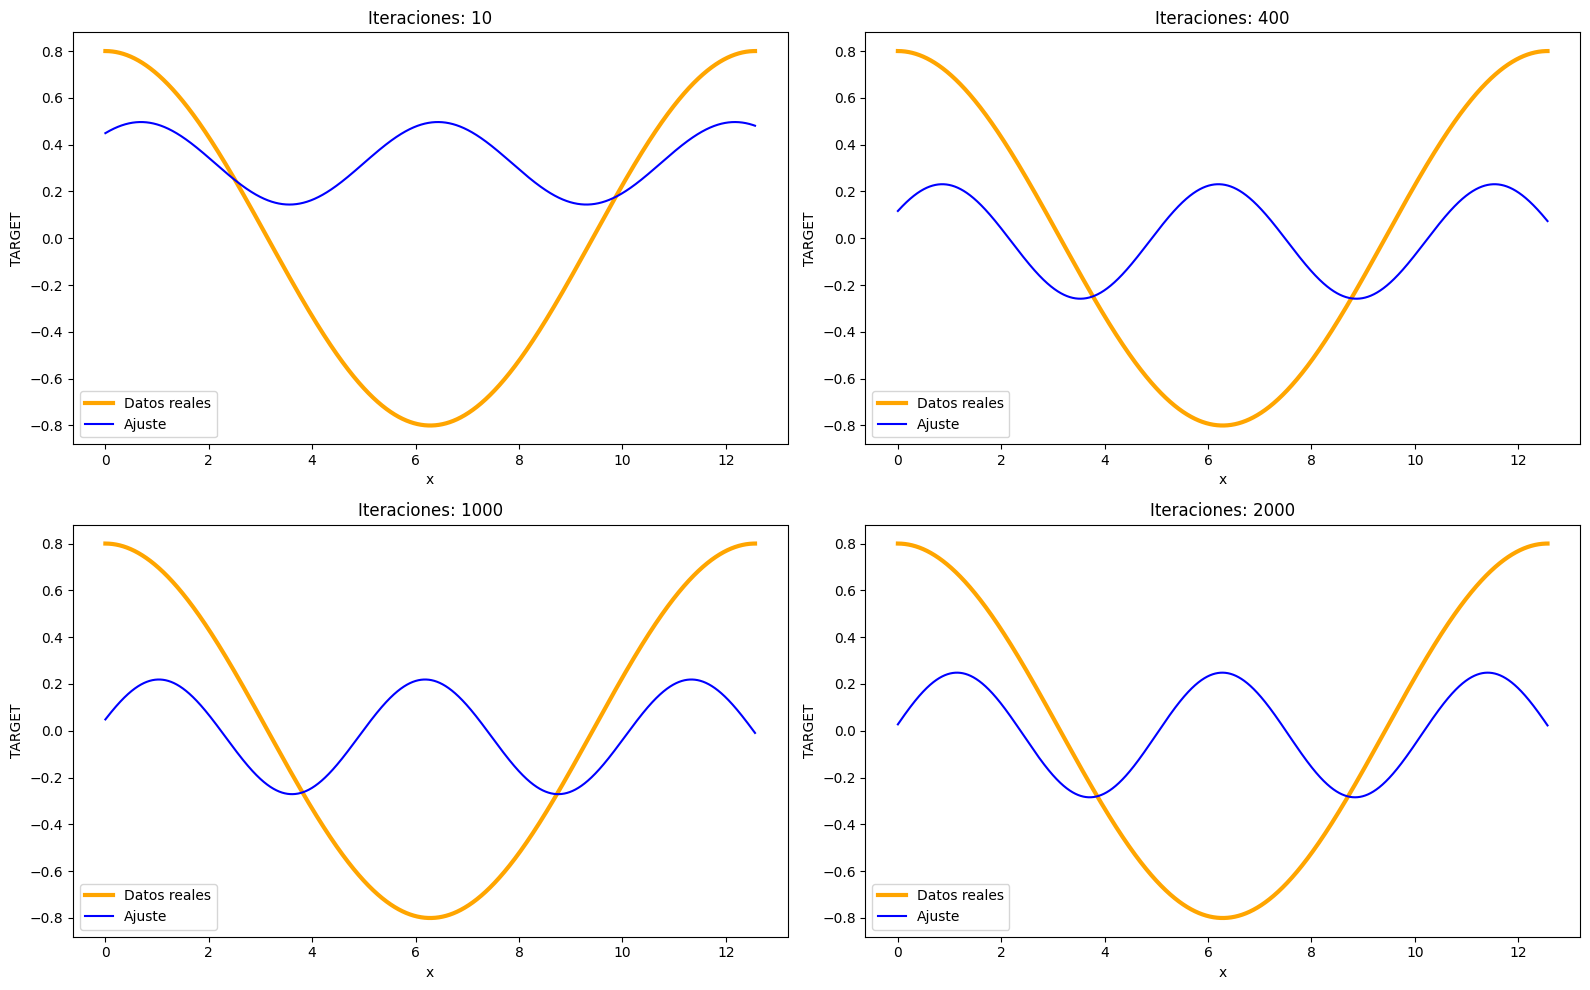

In [14]:
def visualizar_ajuste(x_vals, y_vals, iteraciones=[10, 400, 1000, 2000], tasa=0.05, tamano_lote=100, semilla=42):
    fig, ejes = plt.subplots(2, 2, figsize=(16, 10))
    ejes = ejes.flatten()
    for idx, pasos in enumerate(iteraciones):
        parametros, historial = fit_cosine(
            x_vals, y_vals, 
            learning_rate=tasa, 
            mini_batch=tamano_lote, 
            n_iter=pasos, 
            random_state=semilla
        )
        amp, freq, phase, offset = parametros
        print(f'Error: {historial[-1][-1]}, Frecuencia: {freq}, Amplitud: {amp}, Offset: {offset}')
        ejes[idx].plot(x_vals, y_vals, label='Datos reales', color='orange', linewidth=3)
        ejes[idx].plot(x_vals, cosine_model(parametros, x_vals), label='Ajuste', color='blue')
        ejes[idx].set_title(f'Iteraciones: {pasos}')
        ejes[idx].set_xlabel('x')
        ejes[idx].set_ylabel('TARGET')
        ejes[idx].legend()
    plt.tight_layout()
    plt.show()

visualizar_ajuste(x, y)

Error final: 0.3022573462735799, Frecuencia: -1.2426628457680695, Amplitud: 0.24073268368594788, Offset: -0.049392294846506174


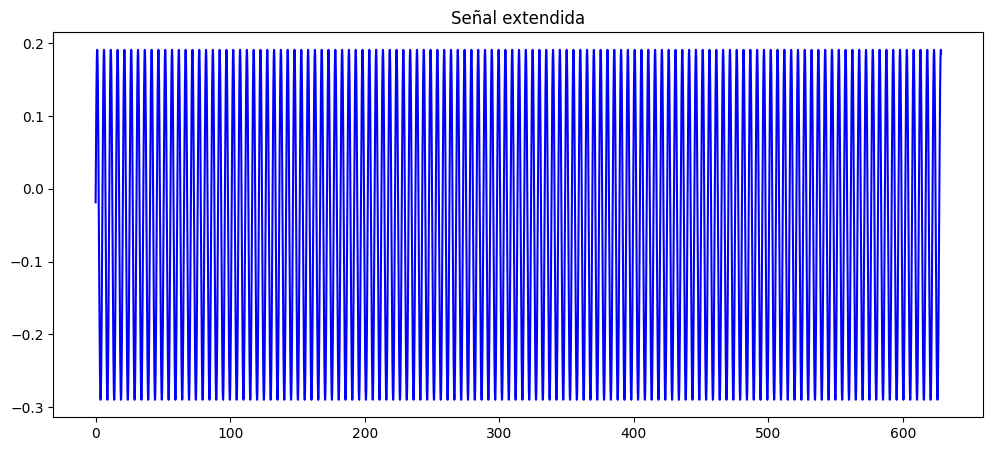

In [15]:
from scipy.io.wavfile import write

# Ajuste de parámetros usando el nuevo método
parametros, historial = fit_cosine(x, y, learning_rate=0.05, mini_batch=100, n_iter=10000, random_state=42)
amplitud, frecuencia, fase, desplazamiento = parametros

x_inicio = np.min(x)
x_extendido = np.arange(x_inicio, 200 * np.pi, 0.01, dtype=np.float32)
senal_larga = cosine_model(parametros, x_extendido)

sd.play(senal_larga)

senal_normalizada = senal_larga / np.max(np.abs(senal_larga))
write('output/audio.wav', 44100, senal_normalizada.astype(np.float32))

print(f'Error final: {historial[-1][-1]}, Frecuencia: {frecuencia}, Amplitud: {amplitud}, Offset: {desplazamiento}')

plt.figure(figsize=(12, 5))
plt.plot(x_extendido, senal_larga, color='blue')
plt.title('Señal extendida')
plt.show()

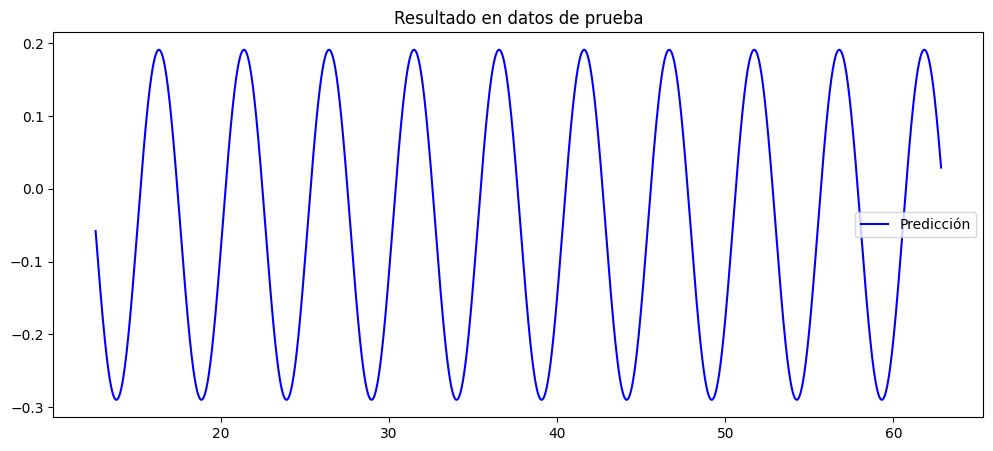

In [ ]:
identificadores = test['example_id'].values
x_prueba = test['x'].values

y_estimado = cosine_model(parametros, x_prueba)

resultado = pd.DataFrame({
    'example_id': identificadores,
    'TARGET': y_estimado
})

resultado.to_csv('output/prediction.csv', index=False)

plt.figure(figsize=(12, 5))
plt.plot(x_prueba, y_estimado, label='Predicción', color='blue')
plt.title('Resultado en datos de prueba')
plt.legend()
plt.show()

### Punto 2


In [19]:
text_train = pd.read_csv('Insumos/2_train.csv')
text_test = pd.read_csv('Insumos/2_test.csv')


In [20]:
categories = ['Entretenimiento', 'Deportes', 'Película y Animación']

text_train['categoria'] = text_train['categoria'].apply(lambda x: x if x in categories else 'Educación y Otros')

text_train

,index,titulo,categoria
0,610,"""De nada sirven los triunfos si la paz no los ...",Película y Animación
1,819,"""Hay mejores formas para uno mostrar su forma ...",Película y Animación
2,637,#LosNacionalesXSeñal - Bahía Cupica,Deportes
3,740,#LosNacionalesXSeñal - Estudiantes Utech balon...,Deportes
4,160,#LosNacionalesXSeñal - Las pruebas de triatlón...,Deportes
...,...,...,...
795,778,¿Qué harías tú? - Esto se puso salsa,Entretenimiento
796,93,¿Qué opinas sobre el machismo?,Película y Animación
797,906,¿Te cortarón los servicios?.. Tranquilo ya est...,Película y Animación
798,440,"Óscar Figueroa, con dos medallas en el Mundial...",Deportes


In [24]:
def construir_bolsa_palabras(serie_titulos):
    # Normalización y limpieza de caracteres
    limpiar = (
        serie_titulos
        .str.lower()
        .str.normalize('NFKD')
        .str.encode('ascii', errors='ignore')
        .str.decode('utf-8')
        .str.replace(r'[^a-z\s]', ' ', regex=True)
    )
    # Extraer vocabulario único preservando orden
    vocabulario = []
    for titulo in limpiar:
        for palabra in titulo.split():
            if palabra not in vocabulario:
                vocabulario.append(palabra)
    indice_palabra = {palabra: idx for idx, palabra in enumerate(vocabulario)}
    # Construir matriz de conteo
    conteos = np.zeros((len(limpiar), len(vocabulario)), dtype=int)
    for fila, titulo in enumerate(limpiar):
        for palabra in titulo.split():
            pos = indice_palabra.get(palabra)
            if pos is not None:
                conteos[fila, pos] += 1
    return pd.DataFrame(conteos, columns=vocabulario, index=serie_titulos)

word_matrix = construir_bolsa_palabras(text_train['titulo'])

In [25]:
palabras_vacias = [
    "a", "aca", "ahi", "ajena", "ajeno", "ajenas", "ajenos", "al", "algo", "algun", "alguna", "alguno", "algunos",
    "alla", "alli", "ambos", "ante", "antes", "aquel", "aquella", "aquello", "aquellos", "aqui", "arriba", "asi",
    "atras", "aun", "aunque", "bajo", "bastante", "bien", "cabe", "cada", "casi", "cierto", "cierta", "ciertos", "ciertas",
    "como", "con", "conmigo", "conseguimos", "conseguir", "consigo", "consigue", "consiguen", "consigues", "contigo",
    "contra", "cual", "cuales", "cualquier", "cualquiera", "cualesquiera", "cuan", "cuando", "cuanto", "cuanta", "cuantos", "cuantas",
    "de", "dejar", "del", "demas", "demasiada", "demasiado", "demasiadas", "demasiados", "dentro", "desde", "donde", "dos",
    "el", "el", "ella", "ello", "ellos", "empleais", "emplean", "emplear", "empleas", "empleo", "en", "encima", "entonces",
    "entre", "era", "eras", "eramos", "eran", "eres", "es", "esa", "ese", "eso", "esas", "estos", "esta", "estaba", "estado",
    "estais", "estamos", "estan", "estar", "este", "esto", "estoy", "etc", "fin", "fue", "fueron", "fui", "fuimos", "gueno",
    "ha", "hace", "haces", "haceis", "hacemos", "hacen", "hacer", "hacia", "hago", "hasta", "incluso", "intenta", "intentas",
    "intentais", "intentamos", "intentan", "intentar", "intento", "ir", "jamas", "junto", "juntos", "la", "lo", "las", "los",
    "largo", "mas", "me", "menos", "mi", "mis", "mia", "mias", "mientras", "mio", "mios", "misma", "mismo", "mismas", "mismos",
    "modo", "mucha", "muchas", "muchisima", "muchisimo", "muchisimas", "muchisimos", "mucho", "muchos", "muy", "nada", "ni",
    "ningun", "ninguna", "ninguno", "ningunos", "no", "nos", "nosotras", "nosotros", "nuestra", "nuestro", "nuestras", "nuestros",
    "nunca", "os", "otra", "otro", "otras", "otros", "para", "parecer", "pero", "poca", "poco", "pocas", "pocos", "podeis",
    "podemos", "poder", "podria", "podrias", "podriais", "podriamos", "podrian", "por", "por que", "porque", "primero", "puede",
    "pueden", "puedo", "pues", "que", "que", "querer", "quien", "quienes", "quienesquiera", "quienquiera", "quiza", "quizas",
    "sabe", "sabes", "saben", "sabeis", "sabemos", "saber", "se", "segun", "ser", "si", "si", "siempre", "siendo", "sin",
    "sino", "so", "sobre", "sois", "solamente", "solo", "solo", "somos", "soy", "sr", "sra", "sres", "sta", "su", "sus",
    "suya", "suyo", "suyas", "suyos", "tal", "tales", "tambien", "tampoco", "tan", "tanta", "tanto", "tantas", "tantos",
    "te", "teneis", "tenemos", "tener", "tengo", "ti", "tiempo", "tiene", "tienen", "toda", "todo", "todas", "todos", "tomar",
    "trabaja", "trabajais", "trabajamos", "trabajan", "trabajar", "trabajas", "tras", "tu", "tu", "tus", "tuya", "tuyo",
    "tuyas", "tuyos", "ultimo", "ultimo", "un", "una", "uno", "unos", "usa", "usas", "usais", "usamos", "usan", "usar", "uso",
    "usted", "ustedes", "va", "van", "vais", "valor", "vamos", "varias", "varios", "vaya", "verdadera", "vosotras", "vosotros",
    "voy", "vuestra", "vuestro", "vuestras", "vuestros", "y", "ya", "yo"
]

columnas_filtradas = [palabra for palabra in word_matrix.columns if palabra not in palabras_vacias]
TF = word_matrix[columnas_filtradas].copy()

categorias_binarias = pd.get_dummies(text_train['categoria'])

for etiqueta in categorias_binarias.columns:
    if categorias_binarias[etiqueta].std() == 0:
        categorias_binarias[etiqueta] = 0
    else:
        categorias_binarias[etiqueta] = (categorias_binarias[etiqueta] - categorias_binarias[etiqueta].mean()) / categorias_binarias[etiqueta].std()

TF = TF.div(TF.sum(axis=1), axis=0).fillna(0)

TF


,sirven,triunfos,paz,corona,lapazhabla,hay,mejores,formas,mostrar,forma,...,sello,magico,puso,opinas,machismo,cortaron,servicios,levantamiento,pesas,competencias
titulo,,,,,,,,,,,,,,,,,,,,,
"""De nada sirven los triunfos si la paz no los corona"" #LaPazHabla",0.2,0.2,0.2,0.2,0.2,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
"""Hay mejores formas para uno mostrar su forma de pensar"" Sofía",0.0,0.0,0.0,0.0,0.0,0.142857,0.142857,0.142857,0.142857,0.142857,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
#LosNacionalesXSeñal - Bahía Cupica,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
#LosNacionalesXSeñal - Estudiantes Utech balonmano,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
#LosNacionalesXSeñal - Las pruebas de triatlón llenaron de emoción al municipio de Prado,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
¿Qué harías tú? - Esto se puso salsa,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.333333,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
¿Qué opinas sobre el machismo?,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.5,0.5,0.000000,0.000000,0.000000,0.000000,0.000000
¿Te cortarón los servicios?.. Tranquilo ya esta aquí Mr. Trance - Estreno 15 de septiembre,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.142857,0.142857,0.000000,0.000000,0.000000


In [27]:
TF = TF.reset_index(drop=True)
dummies = dummies.reset_index(drop=True)

TF.corrwith(dummies['Entretenimiento']).sort_values(ascending=False) 

vemos          0.329902
televidente    0.327930
sub            0.235283
vimos          0.210298
mpg            0.196505
                 ...   
saludo        -0.101020
senal         -0.125085
in            -0.126899
replay        -0.126899
today         -0.126899
Length: 1524, dtype: float64

In [28]:
TF.corrwith(dummies['Deportes']).sort_values(ascending=False) 

in              0.367015
today           0.367015
replay          0.367015
pedaleopor      0.271842
escarabajos     0.271631
                  ...   
glosario       -0.114714
televidentes   -0.117564
cine           -0.117660
televidente    -0.157441
vemos          -0.284491
Length: 1524, dtype: float64

In [29]:
TF.corrwith(dummies['Educación y Otros']).sort_values(ascending=False) 

pepa            0.218770
radionica       0.181841
clip            0.176828
televidentes    0.147917
n               0.143032
                  ...   
televidente    -0.123557
in             -0.123747
replay         -0.123747
today          -0.123747
cine           -0.128250
Length: 1524, dtype: float64

In [30]:
TF.corrwith(dummies['Película y Animación']).sort_values(ascending=False) 

cine               0.311319
recargado          0.164427
molang             0.162851
amigo              0.150123
senalparapensar    0.149795
                     ...   
saludo            -0.085355
in                -0.107222
replay            -0.107222
today             -0.107222
televidentes      -0.111034
Length: 1524, dtype: float64

In [31]:
counts = []

for col in TF.columns:
    count = 0
    for title in text_train['titulo']:
        title = title.lower().replace('á', 'a').replace('é', 'e').replace('í', 'i').replace('ó', 'o').replace('ú', 'u')
        title = ''.join([c if c.isalpha() or c.isspace() else '' for c in title])
        if col in title.split():
            count += 1
    counts.append([col, count])

IDF = pd.DataFrame(counts, columns=['palabra', 'conteo']) 
IDF['log'] = np.log((len(text_train) + 1) / (IDF['conteo'] + 1))
IDF.drop(columns='conteo', inplace=True)
IDF

,palabra,log
0,sirven,5.992714
1,triunfos,5.992714
2,paz,5.299567
3,corona,5.992714
4,lapazhabla,5.992714
...,...,...
1519,cortaron,5.992714
1520,servicios,5.992714
1521,levantamiento,5.992714
1522,pesas,5.992714


In [32]:
vector = IDF.set_index('palabra')['log']
TF_IDF = TF.multiply(vector, axis=1)

TF_IDF

,sirven,triunfos,paz,corona,lapazhabla,hay,mejores,formas,mostrar,forma,...,sello,magico,puso,opinas,machismo,cortaron,servicios,levantamiento,pesas,competencias
0,1.198543,1.198543,1.059913,1.198543,1.198543,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.856102,0.856102,0.856102,0.856102,0.798178,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,1.997571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
796,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,2.996357,2.996357,0.000000,0.000000,0.000000,0.000000,0.000000
797,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.856102,0.856102,0.000000,0.000000,0.000000
798,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.998786,0.998786,0.000000


In [33]:
X = TF_IDF
Y = text_train['categoria']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [34]:
regression = LogisticRegression(max_iter=1000, random_state=42)

regression.fit(X_train, Y_train)

LogisticRegression(max_iter=1000, random_state=42)

Exactitud: 0.675
Sensibilidad: 0.675
Precisión: 0.6847727272727273


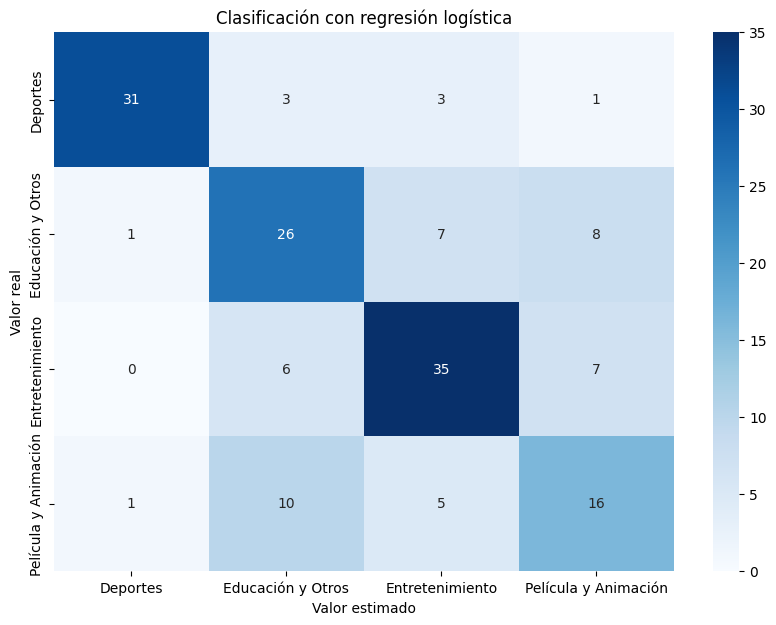

In [ ]:
import seaborn as sns
from sklearn.metrics import recall_score, precision_score, confusion_matrix

predicciones = regression.predict(X_test)

print(f'Exactitud: {accuracy_score(Y_test, predicciones)}')
print(f'Sensibilidad: {recall_score(Y_test, predicciones, average="weighted")}')
print(f'Precisión: {precision_score(Y_test, predicciones, average="weighted")}')


matriz_confusion = confusion_matrix(Y_test, predicciones)
plt.figure(figsize=(10, 7))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', 
            xticklabels=regression.classes_, yticklabels=regression.classes_)
plt.xlabel('Valor estimado')
plt.ylabel('Valor real')
plt.title('Clasificación con regresión logística')
plt.show()
# ...existing code...

In [39]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

Exactitud: 0.625
Sensibilidad: 0.625
Precisión: 0.6906245747286769


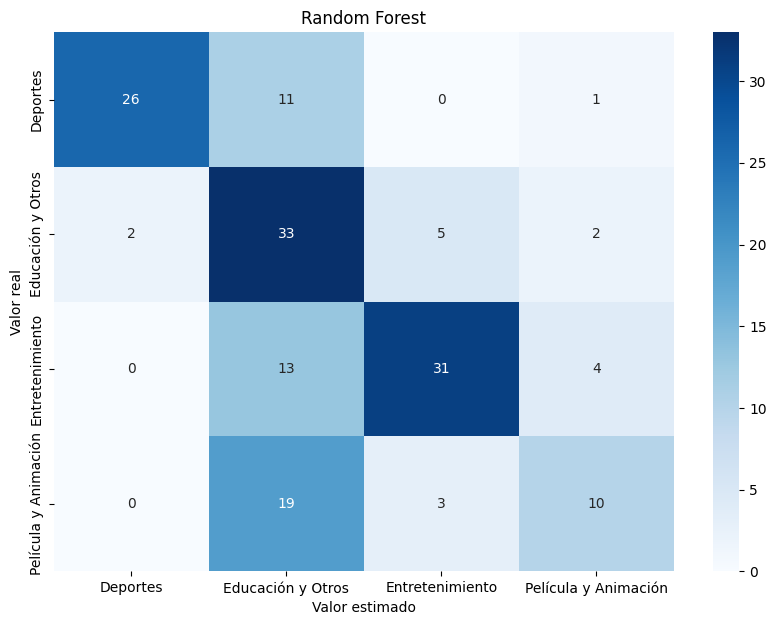

In [41]:
Y_pred_forest = random_forest_model.predict(X_test)

print(f'Exactitud: {accuracy_score(Y_test, Y_pred_forest)}')
print(f'Sensibilidad: {recall_score(Y_test, Y_pred_forest, average="weighted")}')
print(f'Precisión: {precision_score(Y_test, Y_pred_forest, average="weighted")}')

confusion_forest = confusion_matrix(Y_test, Y_pred_forest)
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_forest, annot=True, fmt='d', cmap='Blues', 
            xticklabels=random_forest_model.classes_, yticklabels=random_forest_model.classes_)
plt.xlabel('Valor estimado')
plt.ylabel('Valor real')
plt.title('Random Forest')
plt.show()

In [43]:
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

max_words = 2000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(text_train['titulo'])
sequences = tokenizer.texts_to_sequences(text_train['titulo'])
X_seq = pad_sequences(sequences, maxlen=max_len)

encoder = LabelEncoder()
Y_encoded = encoder.fit_transform(text_train['categoria'])

X_train_LSTM, X_test_LSTM, Y_train_LSTM, Y_test_LSTM = train_test_split(X_seq, Y_encoded, test_size=0.2, random_state=42)

num_classes = len(np.unique(Y_encoded))

lstm_model = Sequential()
lstm_model.add(layers.Embedding(input_dim=max_words, output_dim=10))
lstm_model.add(layers.Bidirectional(layers.LSTM(24, dropout=0.3, recurrent_dropout=0.3)))
lstm_model.add(layers.Dense(num_classes, activation='softmax'))

lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Usa solo validation_data o validation_split, no ambos
lstm_model.fit(X_train_LSTM, Y_train_LSTM, epochs=100, batch_size=500, validation_data=(X_test_LSTM, Y_test_LSTM))

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 715ms/step - accuracy: 0.2254 - loss: 1.3871 - val_accuracy: 0.2750 - val_loss: 1.3850
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.3040 - loss: 1.3849 - val_accuracy: 0.2750 - val_loss: 1.3832
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.2928 - loss: 1.3831 - val_accuracy: 0.3063 - val_loss: 1.3817
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.3041 - loss: 1.3819 - val_accuracy: 0.2937 - val_loss: 1.3805
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.3513 - loss: 1.3806 - val_accuracy: 0.3313 - val_loss: 1.3793
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.3531 - loss: 1.3781 - val_accuracy: 0.3812 - val_loss: 1.3781
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.3747 - loss: 1.3770 - val_accuracy: 0.3750 - val_loss: 1.3767
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.3655 - loss: 1.3757 - val_accuracy: 0.3938 - v

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Exactitud: 0.6875
Sensibilidad: 0.6875
Precisión: 0.690619460117914


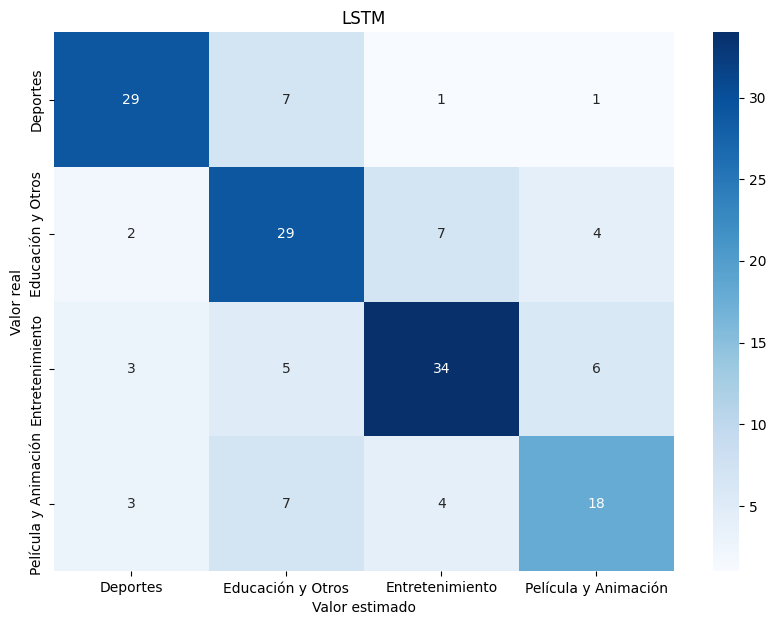

In [44]:
Y_pred_LSTM = lstm_model.predict(X_test_LSTM)
classes = np.argmax(Y_pred_LSTM, axis=1)

print(f'Exactitud: {accuracy_score(Y_test_LSTM, classes)}')
print(f'Sensibilidad: {recall_score(Y_test_LSTM, classes, average="weighted")}')
print(f'Precisión: {precision_score(Y_test_LSTM, classes, average="weighted")}')

confusion_LSTM = confusion_matrix(Y_test_LSTM, classes)
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_LSTM, annot=True, fmt='d', cmap='Blues', 
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Valor estimado')
plt.ylabel('Valor real')
plt.title('LSTM')
plt.show()

In [45]:
titles_test = text_test['titulo'].str.lower().str.replace('á', 'a').str.replace('é', 'e').str.replace('í', 'i').str.replace('ó', 'o').str.replace('ú', 'u')
titles_test = titles_test.str.replace(r'[^a-z\s]', '', regex=True)
words = TF_IDF.columns

matrix_test = np.zeros((len(titles_test), len(words)), dtype=int)

for i, title in enumerate(titles_test):
    for word in title.split():
        if word in words:
            matrix_test[i, list(words).index(word)] += 1

TF_test = pd.DataFrame(matrix_test, columns=words)
TF_test = TF_test.div(TF_test.sum(axis=1), axis=0).fillna(0)
TF_IDF_test = TF_test.multiply(vector, axis=1).fillna(0)

pred_logistic = regression.predict(TF_IDF_test)
log_output = pd.DataFrame({'ID': text_test['index'], 'categoria': pred_logistic})

pred_forest = random_forest_model.predict(TF_IDF_test)
forest_output = pd.DataFrame({'ID': text_test['index'], 'categoria': pred_forest})

seq_test = tokenizer.texts_to_sequences(text_test['titulo'])
X_test_seq = pad_sequences(seq_test, maxlen=max_len)
pred_lstm = lstm_model.predict(X_test_seq)
pred_lstm_cat = encoder.inverse_transform(np.argmax(pred_lstm, axis=1))
lstm_output = pd.DataFrame({'ID': text_test['index'], 'categoria': pred_lstm_cat})

log_output.to_csv('output/prediccion_logistic.csv', index=False)
forest_output.to_csv('output/prediccion_forest.csv', index=False)
lstm_output.to_csv('output/prediccion_lstm.csv', index=False)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
